*RNN_Model_Composers.ipynb* <p style='text-align: right;'> <b> September 20th 2020 </b> </p>
<p style='text-align: right;'> <b> David Diston </b> </p>

# Build an LSTM RNN to Classify Composers

***Once again, substantial trial-and-error tuning was performed when developing this model. The final model iteration is shown here***

I have again chosed to work with LSTM RNN architecture. For this model, in contrast to the first model, I found through trial and error that the optimal number of input notes was 44 input nodes, instead of 88. I also found that the first hidden layer functioned best in the model when it too contained 44 nodes. Optimal performance was found by keeping the second hidden layer a dense layer with 1408 nodes. Again I tried varrying numbers and type of hidden layers, however the optimal choice was quite similar to the first model. This observation was not entirely surprising. 

Since I am now classifying between 10 classes, the final output layer now contains 10 nodes instead of 2.

In [1]:
# Import libraries
import numpy as np
import os
import tensorflow
import random

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
# For this model I will use the same data import function I used for my Human detection RNN model
def training_set(cat, datdir):
    # Using the category labels, I can iterate through each folder
    for category in cat:
        path = os.path.join(datdir, category)
        class_num = categories.index(category)
        # Using the path, and index of the category, I can append both together in a training_data list
        for array in os.listdir(path):
            try:
                midi_array = np.load(os.path.join(path, array))
                training_data.append([midi_array, class_num])
            except Exception as e:
                pass

In [3]:
# Load Training Data
datadirectory = 'C:/Users/David Diston/Documents/CapstonePythonScripts/Composers/Composer_Data'
categories = ['Bach', 'Beethoven', 'Chopin', 'Haydn', 'Liszt', 'Prokofiev', 'Rachmaninoff', 'Ravel', 'Schubert', 'Schumann']

# I'll instantiate my training_data list
training_data = []

# I will pass the path and categories into my data import function
training_set(categories, datadirectory)

# I am going to shuffle the data for more accurate training
random.shuffle(training_data)

X = []
y = []

# For every array/class pair in the data list, I will append the array and class to the X and y variable respectively
for features, label in training_data:
    X.append(features)
    y.append(label)

In [4]:
# I will use the same process as above to load the validation data
datadirectory = 'C:/Users/David Diston/Documents/CapstonePythonScripts/Composers/Composer_Validation_Set_Data'
categories = ['Bach', 'Beethoven', 'Chopin', 'Haydn', 'Liszt', 'Prokofiev', 'Rachmaninoff', 'Ravel', 'Schubert', 'Schumann']
    
training_data = []

# I will pass the path and categories into my data import function
training_set(categories, datadirectory)

# I am going to shuffle the data for more accurate training
random.shuffle(training_data)

X_val = []
y_val = []

# For every array/class pair in the data list, I will append the array and class to the X and y variable respectively
for features, label in training_data:
    X_val.append(features)
    y_val.append(label)

In [5]:
# I will convert all data lists to arrays, and reshape to the correct shape for network input
X_train = np.array(X).reshape(-1, 100, 88)
y_train = np.array(y)
X_val = np.array(X_val).reshape(-1, 100, 88)
y_val = np.array(y_val)

# Here I will normalize all the data to improve training
# Since all note velocities are between 0-127, I can divide by 127 to convert all velocities to between 0 and 1
X_train = X_train / 127
X_val = X_val / 127

In [6]:
# I will instantiate my model
Composers_model = Sequential()

# I am returning a sequence from my first layer to be passed to my next hidden LSTM layer
# Dropout is used after each layer to prevent overfitting
Composers_model.add(LSTM(44, input_shape = (X_train.shape[1:]), activation = 'relu', return_sequences = True))
Composers_model.add(Dropout(0.1))

Composers_model.add(LSTM(44, activation='relu'))
Composers_model.add(Dropout(0.1))

Composers_model.add(Dense(1408, activation='relu'))
Composers_model.add(Dropout(0.1))

# The final output of the model will predict between the ten classes
Composers_model.add(Dense(10, activation='softmax'))

In [7]:
# I am again going to use the adam optimizer with an average learning rate and decay
# I also had issues here with gradient explosion, so I introduce value clipping of 0.5
opt = Adam(lr = 0.001, decay = 0.00001, clipvalue=0.5)

# Here I compile my model with the loss function, the optimizer, an accuracy metric
Composers_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = opt,
    metrics=['accuracy'])

# I will also print a summary to make sure everything looks correct before training
Composers_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 44)           23408     
_________________________________________________________________
dropout (Dropout)            (None, 100, 44)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 44)                15664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 44)                0         
_________________________________________________________________
dense (Dense)                (None, 1408)              63360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [8]:
# By including this checkpoint I can save a copy of the weights from the best performing epoch
# I will identify the best performing epoch by monitoring the validation accuracy
checkpoint = ModelCheckpoint('Models/Composers_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Finally I will fit the model
# I found that after 15 epochs, the accuracy did not significantly improve
Composers_model.fit(X_train, y_train,
               batch_size = 50,
               epochs = 15,
               validation_data=(X_val, y_val),
               callbacks=callbacks_list)

Epoch 1/15
 999/1000 [============================>.] - ETA: 0s - loss: 2.2801 - accuracy: 0.2364
Epoch 00001: val_accuracy improved from -inf to 0.27740, saving model to Models/Composers_model.hdf5
1000/1000 [==============================] - 36s 36ms/step - loss: 2.2801 - accuracy: 0.2364 - val_loss: 1.9777 - val_accuracy: 0.2774
Epoch 2/15
 999/1000 [============================>.] - ETA: 0s - loss: 1.7930 - accuracy: 0.3533
Epoch 00002: val_accuracy improved from 0.27740 to 0.35960, saving model to Models/Composers_model.hdf5
1000/1000 [==============================] - 36s 36ms/step - loss: 1.7929 - accuracy: 0.3533 - val_loss: 1.7863 - val_accuracy: 0.3596
Epoch 3/15
 999/1000 [============================>.] - ETA: 0s - loss: 148890.8281 - accuracy: 0.4022
Epoch 00003: val_accuracy improved from 0.35960 to 0.39800, saving model to Models/Composers_model.hdf5
1000/1000 [==============================] - 36s 36ms/step - loss: 148741.9375 - accuracy: 0.4022 - val_loss: 1.6452 - val

In [9]:
# In addition to saving the best weights with callback, I will also save a copy of the full model I created
Composers_model.save('Models/Composers_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Models/Composers_model\assets


In [2]:
# Import libraries and metrics required for model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [10]:
# I will use the same plotting function used in the first model to plot the confusion matrix
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):

    # Here I am calling the plot of the confusion matrix with the Blue cmap as standard
    # I found that the 'nearest' interpolation produced the clearest results
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # I will also include the colour bar for reference
    plt.colorbar()
    # I set the numer of ticks on the x and y axis to the number of classes which will be useful for multiclass models
    tick_marks = np.arange(len(classes))
    # Here I am going to rotate the x-axis ticks 45 degrees to avoid crouding with the x-axis label
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 15)
    plt.yticks(tick_marks, classes, fontsize = 15)

    # The threshold is half of the maximum value present in the confusion matrix
    thresh = cm.max() / 2
    # This for loop places the correct numerical text in the correct box, and was borrowed from a previous project
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Finally I will include axis labels for clarity
    plt.ylabel('True label', fontsize = 20)
    plt.xlabel('Predicted label', fontsize = 20)
    plt.tight_layout()

#### Load Test Data

In [8]:
# Load Test Data as above
datadirectory = 'C:/Users/David Diston/Documents/CapstonePythonScripts/Composers/Composer_Test_Set_Data'
categories = ['Bach', 'Beethoven', 'Chopin', 'Haydn', 'Liszt', 'Prokofiev', 'Rachmaninoff', 'Ravel', 'Schubert', 'Schumann']

# Similar to above I will instantiate the data list and use the data loading function I created
training_data = []
    
training_set(categories, datadirectory)

# This step is not required, but habit
random.shuffle(training_data)

X_test = []
y_test = []

# Once again I will split the arrays and their class labels into their respective variables
for features, label in training_data:
    X_test.append(features)
    y_test.append(label)

# I will convert to array and reshape the data
X_test = np.array(X_test).reshape(-1, 100, 88)
y_test = np.array(y_test)

# Normalization
X_test = X_test / 127

#### Create Predictions and Plot Confusion Matrix

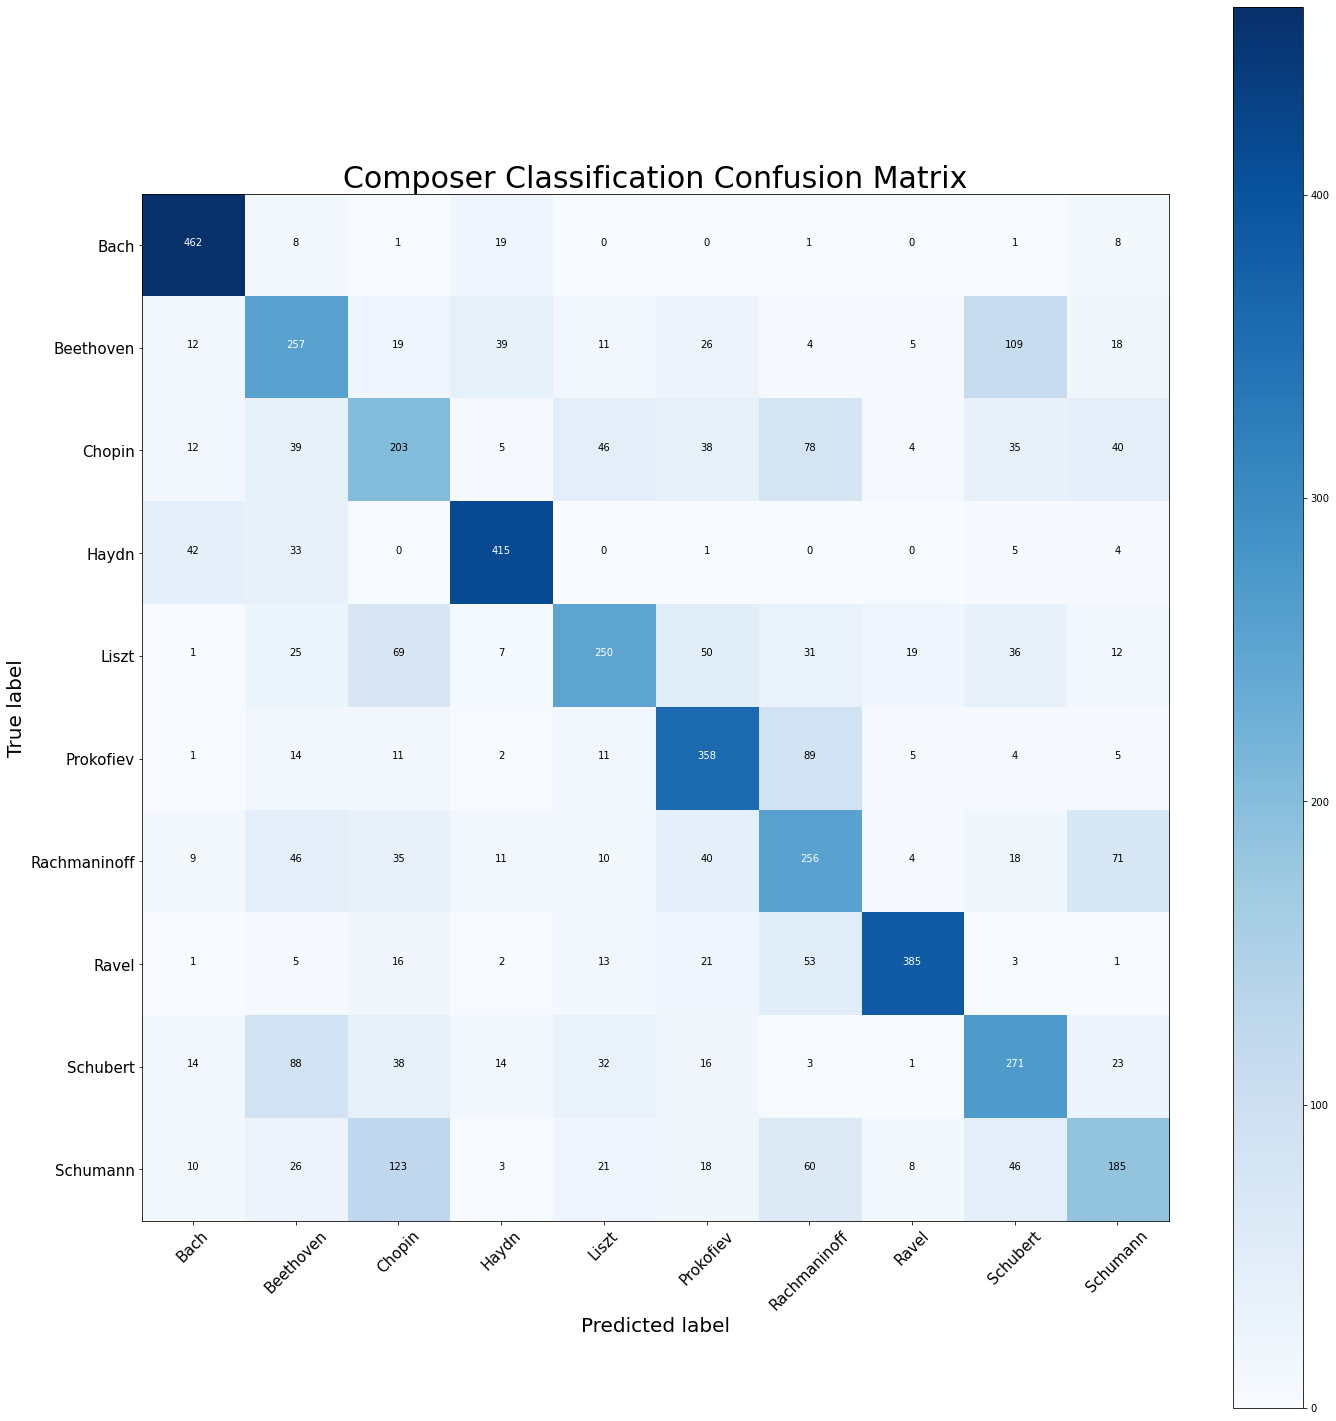

In [11]:
# I will use the predict function to get predictions based on the test set arra
results = Composers_model.predict(X_test, batch_size = 50)

# I will convert the class probabilities into actual class predictions
predicted_classes = np.argmax(results, axis=1)

# Names of predicted classes
class_names = ['Bach', 'Beethoven', 'Chopin', 'Haydn', 'Liszt', 'Prokofiev', 'Rachmaninoff', 'Ravel', 'Schubert', 'Schumann']

# Using sklearn and the true and predicted class labels I will create a confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot the confusion matrix with the above function
plt.figure(figsize = (20,20))
plot_confusion_matrix(cnf_matrix, classes=class_names)
plt.title('Composer Classification Confusion Matrix', fontsize = 30)
plt.show()

In [13]:
# Again for this model I will print a classification report to investigate the errors
CR = classification_report(y_test, predicted_classes)
print(CR)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       500
           1       0.48      0.51      0.49       500
           2       0.39      0.41      0.40       500
           3       0.80      0.83      0.82       500
           4       0.63      0.50      0.56       500
           5       0.63      0.72      0.67       500
           6       0.45      0.51      0.48       500
           7       0.89      0.77      0.83       500
           8       0.51      0.54      0.53       500
           9       0.50      0.37      0.43       500

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



In general this model found a great deal of success. A validation and test accuracy of both ~61% is far from perfect, but very respectable for a 10 class classification problem of this difficulty. Looking at the confusion matrix, there do not appear to be any major standout errors, but rather general error accross the board. The most significant errors appear to be missclassifying Beethoven as Schubert, and Schumann as Chopin. These composers are all from the same Century, and share similar compositional techniques, so this seems like a completely reasonable mistake to make.

There is a high varriance of classification success for different composers, which can be observed in the classification report. f1-score (accuracy) varries from a low of 40% for Chopin, and a high of 87% for Bach. Again these observations made sense based on the data. Firstly Chopin had a varried output of different compositional styles, many of which were represented in the data. Therefore finding similarity and therefore consistency in classification of his music may be difficult. Bach also had an exceptionally large and varried musical output. However upon examining the data, it appears as though the vast majority of Bach performances in the dataset were from his two books of Preudes and Fugues. Since the vast majority of Bach pieces in the dataset are of the same compositional style, it makes sence that the model had an easier time classifying this music.

This theory of how the model is making predictions seems to hold true for other composers. For example Ravel (index 7 in the classification report) had a very streamlined compositional output, and was therefore more easily classifiable. Liszt (index 4) on the other hand had a varried compositional style, and spent much of his time quoting and rewriting the works of past composers in his own style. Therefore it is very understandable that the model had a generally harder time classifying his music.

To delve further into these results and help to confim my model classification hypothesis, I will create additional LSTM RNN models that bin composers by century (i.e. approximate compositional time period), and also compare composers in head-to-head classification models.

<p style='text-align: right;'> <b> Next Step: </b> Preprocess data required to build a Composer classification model binned by Century - <em> Composer_Year_Model_Data_Preparation.ipynb </em> </p>